# Normal LDA Method 
Classifying comments by comparing cosine similarities of probabilities obtained by LDA on synopsis and comments 
with particular threshold

# Importing important libraries

In [1]:
import pandas as pd 
import re 
import string 
import sklearn 
import csv
import numpy as np
from gensim import matutils, models
import scipy.sparse

# Preprocessing of data

In [2]:
#comments dataset path (just change file name for different movies testing)
dataset_file="dataset_shawshank.csv"
#synopsis text file path (just change file name for different movies testing)
synopsis_file="synopsis_shawshank.txt"
df = pd.read_csv(dataset_file)
file = open(synopsis_file,"r")
text=file.read()
sentences = text.split('. ')
   
df2 = pd.DataFrame(sentences, columns=["synopsis"])
df2.to_csv('synopsis3.csv', index=False)
# print(df2.head())

#Splitting dataset into train and test in 8:2 ratio
df_pos=df.loc[df['is_spoiler'] == True]
df_neg=df.loc[df['is_spoiler'] == False]
pos_size=min(1000,df_pos.shape[0])
neg_size=min(1500,df_neg.shape[0])
# print(pos_size,neg_size)
train_size=0.8*(pos_size+neg_size)
test_size=0.2*(pos_size+neg_size)
df_train_pos=df_pos.loc[:0.8*pos_size,:]
df_test_pos=df_pos.loc[0.8*pos_size+1:,:]
df_train_neg=df_neg.loc[:0.8*neg_size,:]
df_test_neg=df_neg.loc[0.8*neg_size+1:,:]
# df_train_neg.to_csv('train.csv', index=False)
frames_train=[df_train_pos,df_train_neg]
frames_test=[df_test_pos,df_test_neg]
df_train=pd.concat(frames_train)
df_test=pd.concat(frames_test)
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)
# print(df.head())

In [3]:
total_size=len(df.index)

In [4]:
#Appending Comment before index number in index column
index=[]
for i in range(len(df_train.index)):
    index.append("Comment "+str(i))
#df.insert(loc=0,column='index',value=index)
df_train['index']=index
df_train.set_index('index', inplace=True)

index2=[]
for i in range(len(df2.index)):
    index2.append("Comment "+str(i))
#df.insert(loc=0,column='index',value=index)
df2['index']=index2
df2.set_index('index', inplace=True)
# df2

In [5]:
#Function for preprocessing 
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
round1 = lambda x: clean_text_round1(x)

In [6]:
#Cleaning both comments and synopsis data
data_clean = pd.DataFrame(df_train.review_text.apply(round1))
data_clean2 = pd.DataFrame(df2.synopsis.apply(round1))
# data_clean

# Preparing document term matrix

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

#Creating document term matrix for comments data with each entry denoting the count of the term in the comment
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.review_text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index

#Creating document term matrix for synopsis data with each entry denoting the count of the term in the comment
cv2 = CountVectorizer(stop_words='english')
data_cv2 = cv2.fit_transform(data_clean2.synopsis)
data_dtm2 = pd.DataFrame(data_cv2.toarray(), columns=cv2.get_feature_names())
data_dtm2.index = data_clean2.index
# data_dtm2

In [8]:
#Creating id to word dictionary for comments data
id_word_dict={}
for i in range(len(data_dtm.columns)):
    id_word_dict[i]=data_dtm.columns[i]
# print(id_word_dict)
tdm = data_dtm.transpose()

#Creating id to word dictionary for synopsis data
id_word_dict2={}
for i in range(len(data_dtm2.columns)):
    id_word_dict2[i]=data_dtm2.columns[i]
# print(id_word_dict2)
tdm2 = data_dtm2.transpose()

In [9]:
#Converting the term document matrix in sparse matrix for preparing corpus of comments data
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

#Converting the term document matrix in sparse matrix for preparing corpus of synopsis data
sparse_counts2 = scipy.sparse.csr_matrix(tdm2)
corpus2 = matutils.Sparse2Corpus(sparse_counts2)

# Running LDA on both comments and synopsis data

In [10]:
total_topics=50
lda = models.LdaModel(corpus=corpus, id2word=id_word_dict, num_topics=total_topics, passes=20)
#lda.print_topics()
lda2 = models.LdaModel(corpus=corpus2, id2word=id_word_dict2, num_topics=total_topics, passes=20)

In [11]:
#lda.print_topics()
#lda2.print_topics()

In [12]:
#storing dictionary of important words obtained by LDA on comments data and storing the maximum probability
#of that word occuring in any topic
word_weight={}
for i in range(total_topics):
    word_topic=lda.print_topic(i).split('+')
    j=0
    for word_probab in word_topic:
        val,wor=word_probab.split('*')
        wor=str(wor)
#         print(wor)
        y=len(wor)
        if j==len(word_topic)-1:
            wor = wor[1:y-1]
        else:
            wor = wor[1:y-2]
#         print(wor)
        if wor in word_weight:
            if word_weight[wor]<val:
                word_weight[wor]=val
        else :
             word_weight[wor]=val
        
        j=j+1

# print(word_weight)
# print(word_weight['start'])

In [13]:
#storing dictionary of important words obtained by LDA on synopsis data and storing the maximum probability
#of that word occuring in any topic
word_weight_synopsis={}
for i in range(total_topics):
    word_topic2=lda2.print_topic(i).split('+')
    j=0
    for word_probab in word_topic2:
        val,wor=word_probab.split('*')        
        wor=str(wor)
        #print(wor)
        y=len(wor)
        if j==len(word_topic2)-1:
            wor = wor[1:y-1]
        else:
            wor = wor[1:y-2]
        #print(wor)
        if wor in word_weight_synopsis:
            if word_weight_synopsis[wor]<val:
                word_weight_synopsis[wor]=val
        else :
             word_weight_synopsis[wor]=val
        
        j=j+1
        
#print(word_weight_synopsis)

# Calculating max probability of words of comments as well as synopsis and storing in dictionary

In [14]:
#Reading training dataset
df3=pd.read_csv('test.csv')
total_size=df3.shape[0]
#total_size

In [15]:
#output_list is the list of cosine similarity score of comments of test data
output_list=[]
#threshold2 is the probability with which a word of comment should occur in synopsis' LDA
#so that the comment matches more with synopsis
threshold2=0.01
counter=0
for j in range(total_size):
    comment_t=df3['review_text'][j]
    if df3['is_spoiler'][j] == 0:
        counter+=1
    #cleaning the new comment of test data
    comment_t=clean_text_round1(comment_t)
    s1=comment_t.split(" ")
    comment_ts=set(s1)
    comment_ts
    sum=0
    sum2=0
    sum3=0
    #normalizing quantity
    for i in word_weight_synopsis.values():
        sum3+=float(i)*float(i)  
    
    #calculating dot product of probabilities of word of new comment if it
    #occurs in both comments' LDA as well as synopsis' LDA 
    for i in comment_ts:
        #normalizing quantity
        if i in word_weight :
            sum2+=float(word_weight[i])*float(word_weight[i])
        #dot product
        if i in word_weight_synopsis and i in word_weight and float(word_weight_synopsis[i])>threshold2:
            sum+=float(word_weight_synopsis[i])*float(word_weight[i])                     
    if sum2!=0 :
        output_list.append(sum/(np.sqrt(sum2)*np.sqrt(sum3)))
    else:
        output_list.append(0)
#print(counter)  
#output_list

# Evaluation

In [16]:
df3['output']=output_list
df3.to_csv('final.csv')
df4=df3

In [17]:
#Function to caculate evaluation metrics such as TP,TN,FP,FN,Recall,Precision,F1-score
def solve(total_size,df3,threshold):
#   total=0
    false_positive=0
    false_negative=0
    true_positive=0
    true_negative=0
#   threshold=0.11

    for i in range(total_size):
        #print(df3['output'][i],threshold,df3['Y'][i])
        if df3['output'][i]>threshold and df3['is_spoiler'][i]==True  :
            true_positive+=1
        if  df3['output'][i]<threshold and df3['is_spoiler'][i]==False :
            true_negative+=1
        if df3['output'][i]>threshold and df3['is_spoiler'][i]==False:
            false_positive+=1
        if df3['output'][i]<threshold and df3['is_spoiler'][i]==True:
            false_negative+=1

#   print(true_positive,true_negative)
#   print(false_negative,false_positive)
#   print((true_negative+true_positive)/total_size)
    accuracy = (true_positive+true_negative)/(total_size)
    precision=true_positive/(true_positive+false_positive)
    recall=true_positive/(true_positive+false_negative)
    f1score=(2*precision*recall)/(precision+recall)
    return (true_positive,true_negative,false_positive,false_negative,f1score,accuracy)
#   print(f1score)

# Calculation of evaluation metrics for different values of threshold hyperparameter

In [20]:
# If you have to run this code using Hyperparameter method ;
# uncomment following code.

# tp = []
# fp = []
# fn = []
# tn = []
# f1 = []
# acc =[]
threshold=0.11
# #threshold2=0.02
# x=0
# for x in range(10):
    #print(word_weight_synopsis)
(true_positive,true_negative,false_positive,false_negative,f1score,accuracy)= solve(total_size,df3,threshold)
# #   print(total_size)
#     tp.append(true_positive)
#     tn.append(false_positive)
#     fp.append(true_negative)
#     fn.append(false_negative)
#     f1.append(f1score)
#     acc.append(accuracy)
#     threshold+=0.01

# print(acc)
# print(f1)
# sample = open('plain-lda-darkknight_result.txt',"a")
# print("iteration:\n",x,file = sample)
# print("\ntopic:",total_topics,file=sample)
# print( "\naccuracy:\n",acc , file = sample)
# print( "\ntrue_positive:\n",tp , file = sample)
# print( "\nfalse_positive:\n",fp , file = sample)
# print( "\ntrue_negative:\n",tn , file = sample)
# print( "\nfalse_negative:\n",fn , file = sample)
# print( "\nf1-score:\n",f1 ,file = sample)
# sample.close() 

In [21]:
# evaluation metrices for top K comments.(The comments are ranked based on cosine similarity values)
df4=pd.read_csv("final.csv")
df4.sort_values(by='output', ascending=False,inplace=True)
df4.to_csv('top_k.csv')
acc = []
pre = []
rec = []
klist = [100,150,200,250,300,350,400,450,500]
for top_k in klist:
    false_positive=0
    false_negative=0
    true_positive=0
    true_negative=0
    best_threshold= 0.11 # add best threshold obtained
    for i in range(top_k):
        if  df4['output'][i]>best_threshold and df4['is_spoiler'][i]==True  :
            true_positive+=1
        if  df4['output'][i]<best_threshold and df4['is_spoiler'][i]==False :
            true_negative+=1
        if  df4['output'][i]>best_threshold and df4['is_spoiler'][i]==False:
            false_positive+=1
        if  df4['output'][i]<best_threshold and df4['is_spoiler'][i]==True:
            false_negative+=1
    total_size = top_k
    accuracy = (true_positive+true_negative)/(total_size)
    acc.append(accuracy)
    precision=true_positive/(true_positive+false_positive)
    pre.append(precision)
    recall=true_positive/(true_positive+false_negative)
    rec.append(recall)

#     f1score=(2*precision*recall)/(precision+recall)
# print(acc)
# print(pre)
# print(rec)

[0.45, 0.46, 0.535, 0.568, 0.61, 0.6142857142857143, 0.6225, 0.6222222222222222, 0.642]
[1.0, 1.0, 0.98989898989899, 0.8596491228070176, 0.7967479674796748, 0.6950354609929078, 0.6242038216560509, 0.5568181818181818, 0.5297297297297298]
[0.45, 0.46, 0.5157894736842106, 0.5157894736842106, 0.5157894736842106, 0.5157894736842106, 0.5157894736842106, 0.5157894736842106, 0.5157894736842106]


# Graphs for Ranking Method :

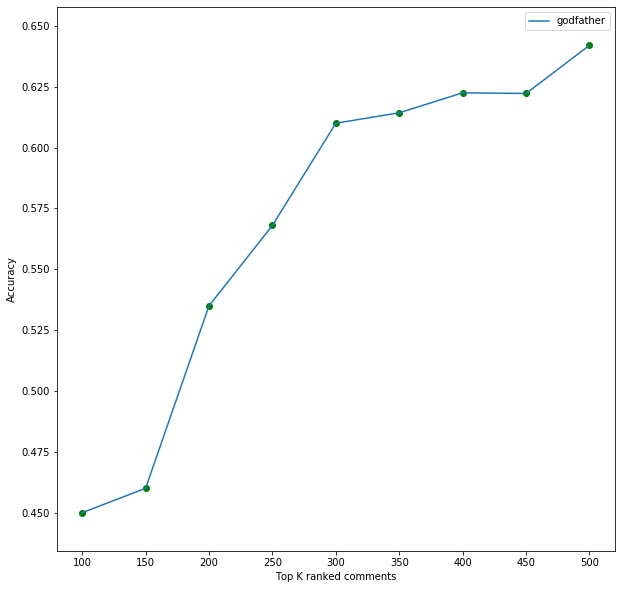

<Figure size 432x288 with 0 Axes>

In [25]:
# Graph for Accuracy vs Top k rated comments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,10))

plt.scatter(klist,acc,marker='o' ,color='g')
line1,=plt.plot(klist,acc)


plt.legend((line1,), ('godfather',))
plt.xlabel('Top K ranked comments')
plt.ylabel('Accuracy')
plt.show()
plt.savefig("plot.jpeg")


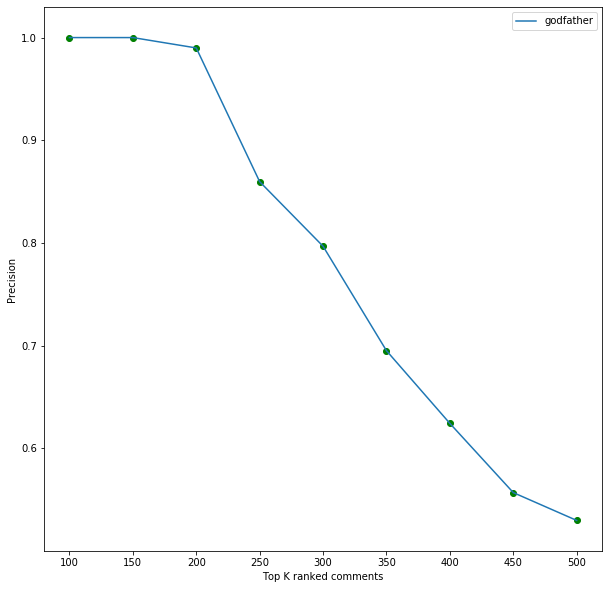

<Figure size 432x288 with 0 Axes>

In [23]:
# Graph for Precision vs Top k rated comments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,10))


plt.scatter(klist,pre,marker='o' ,color='g')
line1,=plt.plot(klist,pre)


plt.legend((line1,), ('godfather',))
plt.xlabel('Top K ranked comments')
plt.ylabel('Precision')
plt.show()
plt.savefig("plot.jpeg")


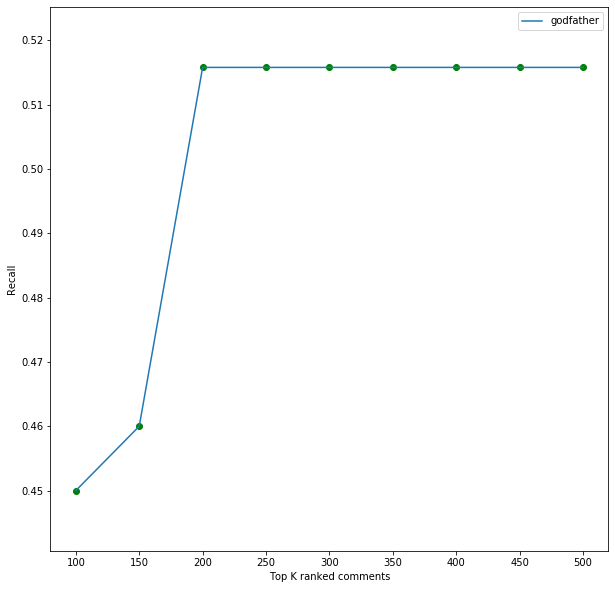

<Figure size 432x288 with 0 Axes>

In [24]:
# Graph for Recall vs Top k rated comments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,10))

plt.scatter(klist,rec,marker='o' ,color='g')
line1,=plt.plot(klist,rec)


plt.legend((line1,), ('godfather',))
plt.xlabel('Top K ranked comments')
plt.ylabel('Recall')
plt.show()
plt.savefig("plot.jpeg")
